# <center>Introduction to Machine Learning with Neuroimaging</center>
<center><b>Written by Luke Chang (luke.j.chang@dartmouth.edu)</b></center>
<center><p>This tutorial will provide a quick introduction to running machine learning analyses using modern python based modules.  We will briefly cover supervised methods using an example pain dataset from Chang et al., (In Press) and Krishnan et al., (Under Review), which is publically available in <a href=http://neurovault.org>neurovault</a>.  We will also provide a brief example of unsupervised based methods to parcellate a region of interest into functionally homogenous subregions using <a href=http://neurosynth.org>neurosynth</a>.</p></center>

## Installation
<ol>
    <li>Install python (I recommend <a href = http://continuum.com>Anaconda</a>, which includes prepackaged core scientific computing packages)</li>
    <li>Install <a href = http://nilearn.org>nilearn</a> (> pip install nilearn)</li>
    <li>Install Luke's <a href = http://github.org/ljchang>nltools</a> toolbox (> pip install git+http://github.org/ljchang/neurolearn)</li>
    <li>Install <a href = http://neurosynth.org>neurosynth</a> (> pip install neurosynth)</li>
</ol>


## Function Definitions

In [10]:
# iPython notebook magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

#General modules
import os
from os.path import join, basename, isdir
from os import makedirs
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle

# Supervised Modules
from pyneurovault import api
import nibabel as nb
import numpy as np
from nltools.analysis import Predict, apply_mask, Roc

# Unsupervised Modules
from neurosynth import Dataset, Clusterer, Masker, Decoder
# from neurosynth.analysis.cluster import cluster_similarity
from nilearn import plotting, datasets
from sklearn.decomposition import RandomizedPCA

# Define output folder
out_folder = "/Users/lukechang/Downloads/nv_tmp"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prediction/Classification

### Download Pain Data from Neurovault

In [3]:
tic = time.time() #Start Timer

# Pain Collection
collection = 504

# Will extract all collections and images in one query to work from
nv = api.NeuroVault()

# Download all images to file
standard = os.path.join(os.path.dirname(api.__file__),'data','MNI152_T1_2mm_brain.nii.gz')
nv.download_images(dest_dir = out_folder,target=standard, collection_ids=[collection],resample=True)

# Create Variables
collection_data = nv.get_images_df().ix[nv.get_images_df().collection_id == collection,:].reset_index()
img_index = sorted((e,i) for i,e in enumerate(collection_data.file))
index = [x[1] for x in img_index]
img_file = [x[0] for x in img_index]

dat = nb.funcs.concat_images([os.path.join(out_folder,'resampled','00' + str(x) + '.nii.gz') for x in collection_data.image_id[index]])
# dat = nb.funcs.concat_images([os.path.join(out_folder,'original',str(x) + '.nii.gz') for x in collection_data.image_id[index]])
holdout = [int(x.split('_')[-2]) for x in img_file]
heat_level = [x.split('_')[-1].split('.')[0] for x in img_file]
Y_dict = {'High':3,'Medium':2,'Low':1}
Y = np.array([Y_dict[x] for x in heat_level])

# Pickle for later use
# Saving the objects:
with open(os.path.join(out_folder,'Pain_Data.pkl'), 'w') as f:
    pickle.dump([dat,holdout,Y], f)

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

Extracting NeuroVault collections meta data...
Found 335 results.
Extracting NeuroVault images meta data...
Found 7201 results.
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=1000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=2000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=3000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=4000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=5000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=6000
Retrieving http://neurovault.org/api/images/?format=json&limit=1000&offset=7000
NeuroVault Object (nv) Includes <nv.images><nv.collections>
Elapsed: 219.52 seconds


### Load Pickled Data
<p>This allows you to save the downloaded data files into a 'pickled' object for fast reloading.  If you've already downloaded the test data and saved it as a pickle object, then start here to save time.</p>

In [11]:
tic = time.time() #Start Timer

# Getting back the objects:
with open(os.path.join(out_folder,'Pain_Data.pkl')) as f:
    dat, holdout, Y = pickle.load(f)
print 'Load Pickled File - Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


Load Pickled File - Elapsed: 23.22 seconds


### Run Prediction Analyses 
<p>This code will initialize a Predict object from nltools. Requires: 
<ol>
    <li>Nibabel Data object</li>
    <li>Y - training labels</li>
    <li>algorithm - algorithm name</li>
    <li>subject_id - vector indicating subject labels</li>
    <li>output_dir- path of folder to save data</li>
    <li>cv_dict - Optional Cross-Validation dictionary</li>
    <li>**{kwargs} - Optional algorithm dictionary</li>
</ol>
</p>
<p>Will run Linear Support Vector Regression ('svr') with 5 fold cross-validation.</p>

overall Root Mean Squared Error: 0.10
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.98
overall CV Correlation: 0.51
         620485 function calls (611829 primitive calls) in 22.299 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   22.299   22.299 <string>:1(<module>)
    11321    0.010    0.000    0.011    0.000 UserDict.py:4(__init__)
       18    0.000    0.000    0.000    0.000 __init__.py:1214(log)
       14    0.000    0.000    0.000    0.000 __init__.py:124(iteritems)
        2    0.000    0.000    0.000    0.000 __init__.py:1335(get_backend)
        7    0.000    0.000    0.000    0.000 __init__.py:1347(is_interactive)
       18    0.000    0.000    0.000    0.000 __init__.py:1358(isEnabledFor)
        2    0.000    0.000    0.000    0.000 __init__.py:143(itervalues)
       11    0.000    0.000    0.000    0.000 __init__.py:25(get_projection_class)
      408    0.000    

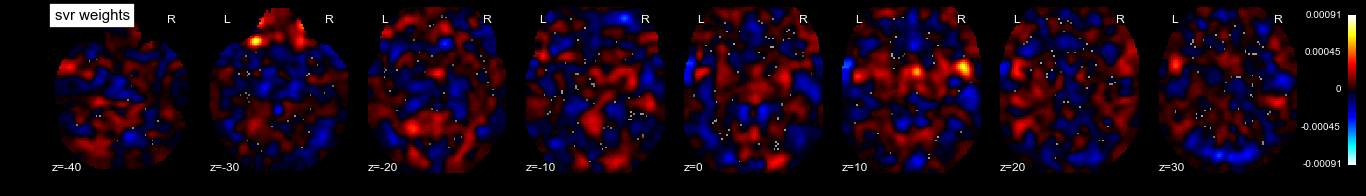

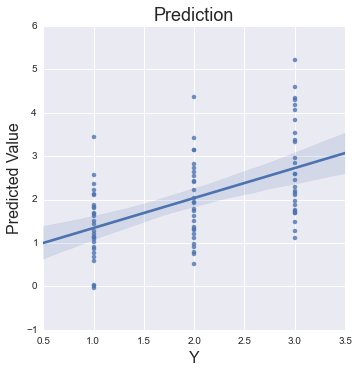

In [197]:
tic = time.time() #Start Timer

# Test Prediction with kfold xVal
svr = Predict(dat,Y,algorithm='svr', output_dir=out_folder, 
              cv_dict = {'type':'kfolds','n_folds':5,'subject_id':holdout}, 
              **{'kernel':"linear"})
svr.predict()

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

In [198]:
out

<p>Run Linear Support Vector Regression with leave one subject out cross-validation (LOSO)</p>

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.95
overall CV Correlation: 0.56
Elapsed: 20.68 seconds


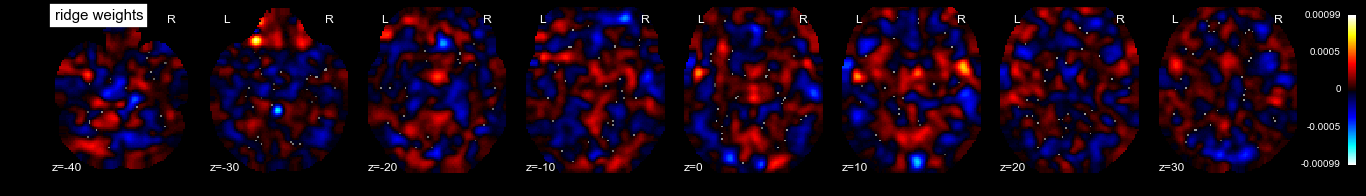

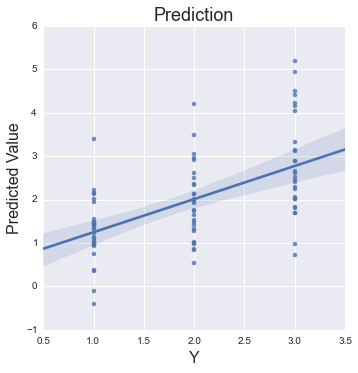

In [193]:
tic = time.time() #Start Timer

# Test Prediction with LOSO xVal
svr = Predict(dat,Y,algorithm='svr', output_dir=out_folder, 
              cv_dict = {'type':'loso','subject_id':holdout}, 
              **{'kernel':"linear"})
svr.predict()

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

<p>Run Ridge Regression with 5 fold Cross-Validation and a nested cross-validation to estimate shrinkage parameter</p>

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.99
overall CV Correlation: 0.52
Total Elapsed: 6.39 seconds


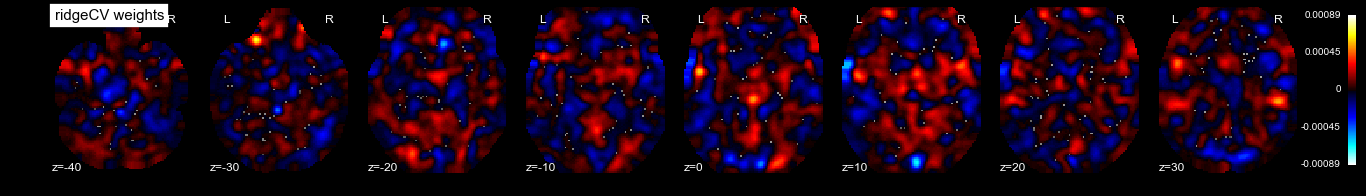

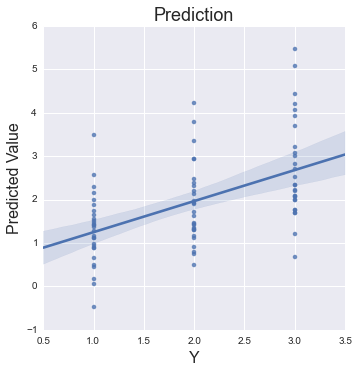

In [176]:
tic = time.time() #Start Timer

# Test Ridge with kfold xVal + grid search for regularization
ridge = Predict(dat, Y, algorithm='ridgeCV',output_dir=out_folder, 
                cv_dict = {'type':'kfolds','n_folds':5,'subject_id':holdout},
                **{'alphas':np.linspace(.1, 10, 5)})
ridge.predict()

print 'Total Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

<p>Run Principal Components Regression with no Cross-Validation.  This pattern should be very similar to the pain pattern reported in Krishnan et al., (Under Review).  Principal Components Regression is much slower than the other linear methods, but scales well when feature set is large</p>

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.93
overall CV Correlation: 0.56
Total Elapsed: 49.84 seconds


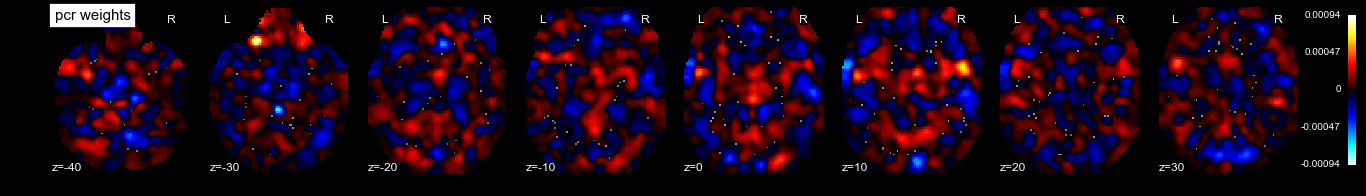

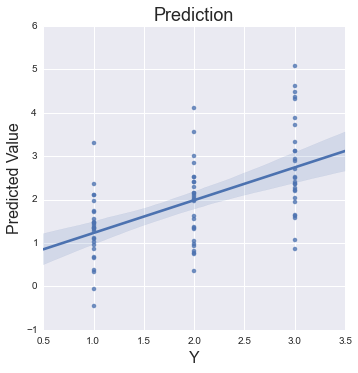

In [177]:
tic = time.time() #Start Timer

# Principal Components Regression
pcr = Predict(dat,Y,algorithm='pcr', output_dir=out_folder, 
              cv_dict = {'type':'kfolds','n_folds':5,'subject_id':holdout})
pcr.predict()

print 'Total Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

<p>You might be interested in only training a pattern on a subset of the brain using an anatomical mask.  Here we use a mask of subcortex.</p>

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.83
overall CV Correlation: 0.62
Elapsed: 2.94 seconds


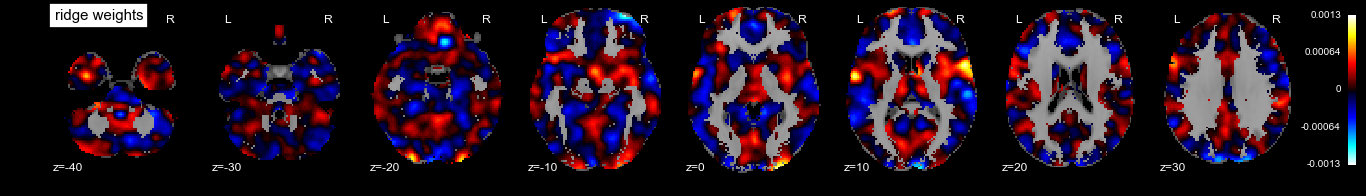

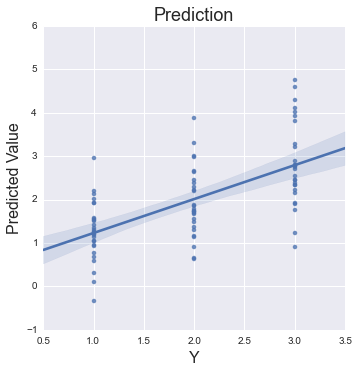

In [195]:
tic = time.time() #Start Timer

from nltools.util import get_resource_path

mask = nb.load(os.path.join(get_resource_path(),'gray_matter_mask.nii.gz'))

# Test Prediction with kfold xVal
ridge = Predict(dat,Y,algorithm='ridge', output_dir=out_folder, 
              cv_dict = {'type':'kfolds','n_folds':5, 'subject_id':holdout}, 
              mask = mask)
ridge.predict()

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


### Apply Mask
<p>After training a pattern we are typically interested in testing it on new data to see how sensitive and specific it might be to the construct it was trained to predict.  Here we provide an example of applying it to a new dataset using the 'dot_product' method.  This will produce a scalar prediction per image akin to regression (don't forget to add the intercept!). We can also use a standardized method, which examines the overall spatial correlation between two images (i.e., 'correlation').</p>

Elapsed: 3.62 seconds


/usr/local/lib/python2.7/site-packages/nilearn/signal.py:50: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


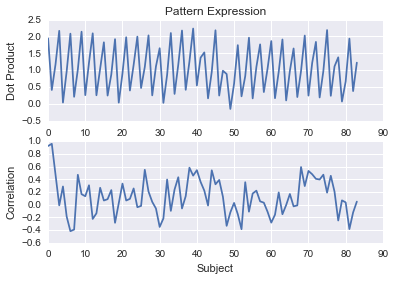

In [199]:
tic = time.time() #Start Timer

# Load data using nibabel
pines = nb.load(os.path.join(out_folder, 'ridgeCV_weightmap.nii.gz'))

pexpd = apply_mask(data=dat, weight_map=pines, output_dir=out_folder, method='dot_product', save_output=True)
pexpc = apply_mask(data=dat, weight_map=pines, output_dir=out_folder, method='correlation', save_output=True)

plt.subplot(2, 1, 1)
plt.plot(pexpd)
plt.title('Pattern Expression')
plt.ylabel('Dot Product')

plt.subplot(2, 1, 2)
plt.plot(pexpc)
plt.xlabel('Subject')
plt.ylabel('Correlation')

print 'Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer


### ROC Plot
<p>We are often interested in evaluating how well a pattern can discriminate between different classes of data.  Here we apply a pattern to a new dataset and evaluate how well it can discriminate between high and low pain using single-interval classification.  We use the Roc class to initialize an Roc object and the plot() and summary() methods to run the analyses.  We could also just run the calculate() method to run the analysis without plotting.</p>

------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           0.77
Accuracy SE:        0.10
Accuracy p-value:   0.00
Sensitivity:        0.89
Specificity:        0.64
AUC:                0.85
PPV:                0.71
------------------------
Total Elapsed: 0.70 seconds


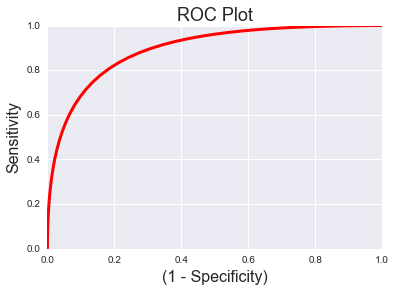

In [201]:
tic = time.time() #Start Timer

# Create Variables
include = (svr.Y==3) | (svr.Y==1)
input_values = svr.yfit_xval[include]
binary_outcome = svr.Y[include]
binary_outcome = binary_outcome==3

# Single-Interval
roc = Roc(input_values=input_values, binary_outcome=binary_outcome)
roc.plot()
roc.summary()

print 'Total Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

<p>The above example uses single-interval classification, which attempts to determine the optimal classification interval.  However, sometimes we are intersted in directly comparing responses to two images within the same person.  In this situation we should use forced-choice classification, which looks at the relative classification accuracy between two images.</p>

------------------------
.:ROC Analysis Summary:.
------------------------
Accuracy:           1.00
Accuracy SE:        0.19
Accuracy p-value:   0.00
Sensitivity:        1.00
Specificity:        1.00
AUC:                0.00
PPV:                1.00
------------------------
Total Elapsed: 0.73 seconds


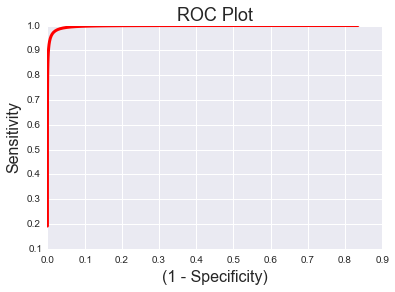

In [202]:
tic = time.time() #Start Timer

# Forced Choice 
roc_fc = Roc(input_values=input_values, binary_outcome=binary_outcome, forced_choice=True)
roc_fc.plot()
roc_fc.summary()

print 'Total Elapsed: %.2f seconds' % (time.time() - tic) #Stop timer

# Coactivation Based Clustering w/ Neurosynth
<p>Sometimes we are interested in understanding how a region of interested might be functionally organized.  One increasingly popular technique is to parcellate the region based on shared patterns of functional connectivity.  These functional correlations can be derived from functional connectivity using resting-state fMRI or functional coactivation from meta-analyses.  See our <a href=http://cosanlab.com/static/papers/Changetal2013CerCor.pdf>paper</a> on the insula for example (<a href = http://neurovault.org/collections/13/>Images</a> can be downloaded from neurovault).  This tutorial will show how to perform a similar functional coactivation based parcellation of a region using <a href=http://neurosynth.org>neurosynth</a> tools.</p>
<p>The basic idea is to:
<ol>
    <li>Create a binary mask of a region (we will use TPJ as example)</li>
    <li>Reduce the dimensionality of voxels in the the neurosynth dataset (we use randomizedPCA)</li>
    <li>Calculate the similarity coefficient for every voxel in the mask with the neurosynth components (we use pearson correlation)</li>
    <li>Cluster the voxels in the mask based on shared patterns of correlation (we will use k-means clustering)</li>
    <li>Decode the function of each subregion in the mask using Neurosynth terms (we use topic modeling to reduce dimensionality)</li>
</ol>
</p>
<p>Warning: This can take a lot of RAM if you use the full neurosynth Dataset!</p>

###Initialize Clusterer

In [ ]:
# Initialize main clustering object: use PCA with 100 components for dimensionality reduction;
# keep all voxels with minimum of 100 studies (approx. 1% base rate).
reducer = RandomizedPCA(100)
roi_mask = os.path.join(out_folder,'Clustering/Masks/ROIs/FSL_TPJ.nii.gz')

clstr = Clusterer(dataset, 'coactivation', output_dir=os.path.join(out_folder,'Clustering'), 
    min_studies_per_voxel=100, reduce_reference=reducer, roi_mask=roi_mask)

###Run Clustering

In [ ]:
clstr.cluster(algorithm='kmeans', n_clusters=range(2,11,1),
              bundle=False, coactivation_maps=True, 
              precomputed_distances=True)

### Plot Slice Montages

In [ ]:
K = range(2,11,1)
fig, axes = plt.subplots(len(K), 1)

for i, k in enumerate(K):
    plotting.plot_roi(os.path.join(out_folder,'Clustering/kmeans_k%d/kmeans_k%dcluster_labels.nii.gz' % (k, k)),
                  title="Whole-brain k-means clustering (k = %d)" % k, display_mode='x',
                  cut_coords=range(-60,-45,5) + range(50,65,5), axes=axes[i])
fig.set_size_inches((15, 20))
fig.savefig(os.path.join(out_folder,'Clustering/Sagittal_Slice_Montage.png'))

### Decode with Neurosynth

In [ ]:
# Decoding Polar Plots
K = range(2,11,1)

dcdr = Decoder(dataset, method='roi')
for i in K:
    res = dcdr.decode(os.path.join(out_folder,'Clustering/kmeans_k' + str(i) + '/kmeans_k' + str(i) + 'cluster_labels.nii.gz'),
                  save=os.path.join(out_folder,'Clustering/kmeans_k' + str(i) + '/decoding_results_z.txt'), value='r')
    _ = dcdr.plot_polar(res, overplot=True, n_top=2)
    _.savefig(os.path.join(out_folder,'Clustering/kmeans_k' + str(i) + '/Decode_PolarPlot_k' + str(i) + '.pdf'))